In [1]:
include("fld.jl")
using PyPlot
using CSV

INFO: Precompiling module JLD.
ERROR: LoadError: HDF5 not properly installed. Please run Pkg.build("HDF5")
Stacktrace:
 [1] error(::String) at ./error.jl:21
 [2] include_from_node1(::String) at ./loading.jl:576
 [3] include(::String) at ./sysimg.jl:14
 [4] anonymous at ./<missing>:2
while loading /Users/ryanmcclarren/.julia/v0.6/HDF5/src/HDF5.jl, in expression starting on line 38
ERROR: LoadError: Failed to precompile HDF5 to /Users/ryanmcclarren/.julia/lib/v0.6/HDF5.ji.
Stacktrace:
 [1] compilecache(::String) at ./loading.jl:710
 [2] _require(::Symbol) at ./loading.jl:463
 [3] require(::Symbol) at ./loading.jl:405
 [4] include_from_node1(::String) at ./loading.jl:576
 [5] include(::String) at ./sysimg.jl:14
 [6] anonymous at ./<missing>:2
while loading /Users/ryanmcclarren/.julia/v0.6/JLD/src/JLD.jl, in expression starting on line 4


LoadError: LoadError: [91mFailed to precompile JLD to /Users/ryanmcclarren/.julia/lib/v0.6/JLD.ji.[39m
while loading /Users/ryanmcclarren/Dropbox/Papers/LANL/Flux Limited Diffusion/fld.jl, in expression starting on line 9

In [2]:
tfinal = 10.
println("Running until time $(tfinal)")
Nr = 40
Nz = 140
Lz = 7.
println("Size of domain in Z is $(Lz)")
Lr = 2.
dr = Lr/Nr
dz = Lz/Nz

T = zeros(Nr*Nz)+1.0e-8

function sigma_func(t,T,Nr,Nz,Lr,Lz)
    sigma = zeros(Nr,Nz) + 10*20.0
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                sigma[i,j] = 0.01*20
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                sigma[i,j] = 0.01*20
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                sigma[i,j] = 0.01*20
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                sigma[i,j] = 0.01*20
            end
        end
    end
    sigma
end

function Cv_func(t,T,Nr,Nz,Lr,Lz)
    cv = zeros(Nr,Nz) + 10*0.05
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                cv[i,j] = 0.01*0.05
            end
        end
    end
    cv                 
end
function D_func(t,T,Nr,Nz,Lr,Lz,Er_tmp,sigma) 
    #larsen n=2 flux limiter
    Er = reshape(T,Nr,Nz)
    idz = Nz/Lz
    idr = Nr/Lr
    D = zeros(Nr,Nz) 
    for i in 1:Nr
        for j in 1:Nz
            gradE = zeros(2)
            if (i > 1)
                gradE[1] += (Er[i,j]-Er[i-1,j])*idr*0.5
            end
            if (i < Nr)
                gradE[1] += (Er[i+1,j]-Er[i,j])*idr*0.5
            end
            if (j > 1)
                gradE[2] += (Er[i,j]-Er[i,j-1])*idz*0.5
            end
            if (j < Nz)
                gradE[2] += (Er[i,j+1]-Er[i,j])*idz*0.5
            end
            normGradE = sqrt(gradE[1]^2 + gradE[2]^2)/(Er[i,j] + 1e-12)
            
            D[i,j] = 1.0./sqrt( (3.0*sigma[i,j])^2 + normGradE^2)
        end
    end
    D
end

function EOS(t,T,Nr,Nz,Lr,Lz)
    T_tmp = reshape(T,Nr,Nz)
    E = zeros(Nr,Nz) + T_tmp*(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            end
        end
    end
    reshape(E,Nr*Nz)                 
end

function invEOS(t,T,Nr,Nz,Lr,Lz)
    E_tmp = reshape(T,Nr,Nz)
    T = zeros(Nr,Nz) + E_tmp/(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 2.75) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 4.25) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            end
        end
    end
    reshape(T,Nr*Nz)                 
end

function Q_func(t,T,Nr,Nz,Lr,Lz)
    Q = zeros(Nr,Nz)
end

rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
R,Z = meshgrid(rcenter,zcenter)
sig = sigma_func(0,T,Nr,Nz,Lr,Lz)
pcolormesh(Z,R,(sig))

Running until time 10.0
Size of domain in Z is 7.0


LoadError: [91mUndefVarError: meshgrid not defined[39m

In [3]:
dt = 0.005
times, Er_t,T_t = time_dep_RT(tfinal,dt,T,zeros(Nr*Nz),D_func, sigma_func, Q_func,Cv_func,EOS,invEOS,
                      Nr, Nz, Lr, Lz, lower_z=a*.3^4, upper_z="vacuum", upper_r="refl",LOUD=-1,
    fname="runs/crooked_pipe$(Nr)_$(Nz)_$(dt).jld");

LoadError: [91mUndefVarError: time_dep_RT not defined[39m

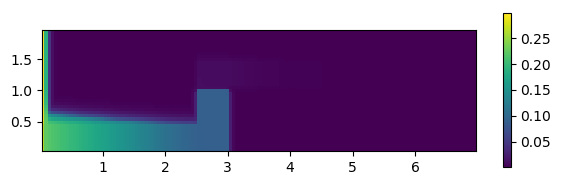

(0.025, 6.975, 0.025, 1.975)

In [9]:
Tr_plot = reshape((Er_t[:,size(times)[1]]/a).^.25,Nr,Nz)
figure(figsize=(7,2))
pcolormesh(Z,R,Tr_plot)
colorbar()
axis("scaled")

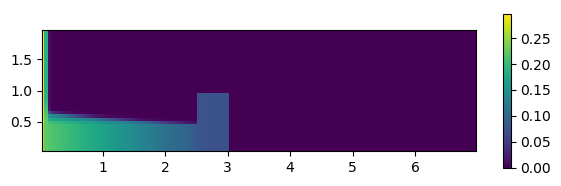

(0.025, 6.975, 0.025, 1.975)

In [10]:
T_plot = reshape(T_t[:,size(times)[1]],Nr,Nz)
figure(figsize=(7,2))
pcolormesh(Z,R,T_plot)
colorbar()
ylim(0,2)
xlim(0,7)
axis("scaled")

In [2]:
Pkg.build("HDF5")

INFO: Building Homebrew


Already up-to-date.


INFO: Building CMakeWrapper
INFO: Building Blosc
INFO: Building HDF5


==> Installing gcc from staticfloat/juliatranslated


Error: Operation already in progress for gcc.formula
Another active Homebrew process is already using gcc.formula.
Please wait for it to finish or terminate it to continue.
================================[ ERROR: HDF5 ]=================================

LoadError: failed process: Process(`/Users/ryanmcclarren/.julia/v0.6/Homebrew/deps/usr/bin/brew install --ignore-dependencies staticfloat/juliatranslated/gcc`, ProcessExited(1)) [1]
while loading /Users/ryanmcclarren/.julia/v0.6/HDF5/deps/build.jl, in expression starting on line 41


================================[ BUILD ERRORS ]================================


 - packages with build errors remain installed in /Users/ryanmcclarren/.julia/v0.6
 - build the package(s) and all dependencies with `Pkg.build("HDF5")`
 - build a single package by running its `deps/build.jl` script



In [ ]:
d